In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Semilla para reproducibilidad
torch.manual_seed(42)

# Red profunda con activaciones especificadas
class DeepNetwork(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        layers = []
        input_size = 1
        hidden_size = 128
        depth = 20  # número de capas ocultas

        for _ in range(depth):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(activation_fn())
            input_size = hidden_size

        layers.append(nn.Linear(hidden_size, 1))  # capa de salida
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Función para observar los gradientes de cada capa
def get_gradients(model, x, loss_fn):
    x = x.clone().detach().requires_grad_(True)
    output = model(x)
    loss = loss_fn(output, torch.ones_like(output))
    loss.backward()
    grads = []

    for name, param in model.named_parameters():
        if "weight" in name:
            grads.append(param.grad.norm().item())  # norma del gradiente del peso

    return grads


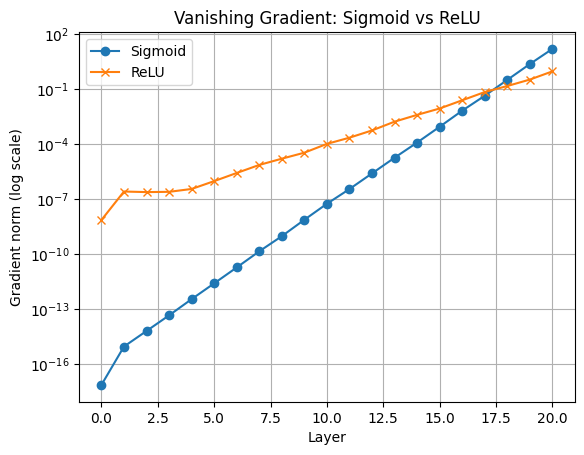

In [3]:
# Crear entradas y redes
x = torch.randn(1, 1)

model_sigmoid = DeepNetwork(nn.Sigmoid)
model_relu = DeepNetwork(nn.ReLU)

loss_fn = nn.MSELoss()

# Obtener gradientes
grads_sigmoid = get_gradients(model_sigmoid, x, loss_fn)
grads_relu = get_gradients(model_relu, x, loss_fn)

# Graficar
plt.plot(grads_sigmoid, label="Sigmoid", marker="o")
plt.plot(grads_relu, label="ReLU", marker="x")
plt.yscale("log")
plt.xlabel("Layer")
plt.ylabel("Gradient norm (log scale)")
plt.title("Vanishing Gradient: Sigmoid vs ReLU")
plt.legend()
plt.grid(True)
plt.show()

# Batch Normalization

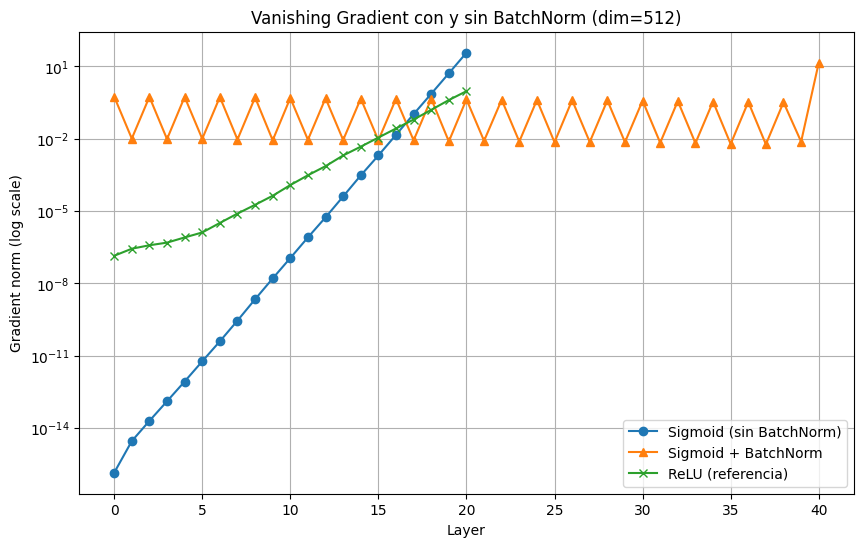

In [4]:
torch.manual_seed(0)

# Red profunda con opción de batch norm
class DeepHighDimNetwork(nn.Module):
    def __init__(self, input_dim, activation_fn, use_batchnorm=False):
        super().__init__()
        layers = []
        hidden_size = 512
        depth = 20

        for i in range(depth):
            layers.append(nn.Linear(input_dim, hidden_size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(activation_fn())
            input_dim = hidden_size

        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def get_gradients(model, x, loss_fn):
    x = x.clone().detach().requires_grad_(True)
    output = model(x)
    loss = loss_fn(output, torch.ones_like(output))
    loss.backward()

    grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            grads.append(param.grad.norm().item())

    return grads

# Datos de entrada de alta dimensión
input_dim = 512
x = torch.randn(32, input_dim)

# Modelos
model_sigmoid = DeepHighDimNetwork(input_dim, nn.Sigmoid, use_batchnorm=False)
model_sigmoid_bn = DeepHighDimNetwork(input_dim, nn.Sigmoid, use_batchnorm=True)
model_relu = DeepHighDimNetwork(input_dim, nn.ReLU, use_batchnorm=False)

loss_fn = nn.MSELoss()

# Obtener gradientes
grads_sigmoid = get_gradients(model_sigmoid, x, loss_fn)
grads_sigmoid_bn = get_gradients(model_sigmoid_bn, x, loss_fn)
grads_relu = get_gradients(model_relu, x, loss_fn)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(grads_sigmoid, label="Sigmoid (sin BatchNorm)", marker="o")
plt.plot(grads_sigmoid_bn, label="Sigmoid + BatchNorm", marker="^")
plt.plot(grads_relu, label="ReLU (referencia)", marker="x")
plt.yscale("log")
plt.xlabel("Layer")
plt.ylabel("Gradient norm (log scale)")
plt.title("Vanishing Gradient con y sin BatchNorm (dim=512)")
plt.legend()
plt.grid(True)
plt.show()